### Load the dataset to work with

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install unrar

In [ ]:
!ls /content/drive/MyDrive/ocr_arabic_dataset.rar

/content/drive/MyDrive/ocr_arabic_dataset.rar


In [ ]:
!cp /content/drive/MyDrive/ocr_arabic_dataset.rar /content/

In [ ]:
!mkdir ocr_arabic_dataset
!unrar x /content/drive/MyDrive/creative_arabic_digits.rar ocr_dataset/

In [ ]:
!rm -r test val train ocr_arabic_dataset ocr_dataset.rar

rm: cannot remove 'ocr_dataset.rar': No such file or directory


### Split data into: Train, Val and Test

In [ ]:
import os
import shutil
import random

def split_data(src_dir, train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Splits data from the source directory into train, validation, and test directories.
    Args:
        src_dir (str): The source directory where the original images are located.
        train_dir (str): Directory to store the training images.
        val_dir (str): Directory to store the validation images.
        test_dir (str): Directory to store the test images.
        train_ratio (float): Ratio of training data.
        val_ratio (float): Ratio of validation data.
        test_ratio (float): Ratio of test data.
    """
    # Ensure the directories exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Loop through each subdirectory (which corresponds to a class)
    for label in os.listdir(src_dir):
        label_path = os.path.join(src_dir, label)
        if os.path.isdir(label_path):
            # Create subdirectories in train, val, and test directories
            os.makedirs(os.path.join(train_dir, label), exist_ok=True)
            os.makedirs(os.path.join(val_dir, label), exist_ok=True)
            os.makedirs(os.path.join(test_dir, label), exist_ok=True)

            # Get the list of image files
            image_files = [f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))]

            # Shuffle the image files to ensure random splitting
            random.shuffle(image_files)

            # Calculate the number of images for each split
            total_images = len(image_files)
            train_end = int(train_ratio * total_images)
            val_end = int((train_ratio + val_ratio) * total_images)

            # Split the data into train, val, and test
            train_images = image_files[:train_end]
            val_images = image_files[train_end:val_end]
            test_images = image_files[val_end:]

            # Move the images to the respective directories
            for img in train_images:
                shutil.move(os.path.join(label_path, img), os.path.join(train_dir, label, img))
            for img in val_images:
                shutil.move(os.path.join(label_path, img), os.path.join(val_dir, label, img))
            for img in test_images:
                shutil.move(os.path.join(label_path, img), os.path.join(test_dir, label, img))

            print(f"Class '{label}' split: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")

# Define the paths
src_dir = 'ocr_dataset'  # Original OCR dataset directory
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Call the split function
split_data(src_dir, train_dir, val_dir, test_dir)

Class '٦' split: 3500 train, 1000 val, 500 test
Class '٧' split: 3500 train, 1000 val, 500 test
Class '٨' split: 3500 train, 1000 val, 500 test
Class '٠' split: 3500 train, 1000 val, 500 test
Class '٣' split: 3500 train, 1000 val, 500 test
Class '٥' split: 3500 train, 1000 val, 500 test
Class '٤' split: 3500 train, 1000 val, 500 test
Class '٩' split: 3500 train, 1000 val, 500 test
Class '٢' split: 3500 train, 1000 val, 500 test
Class '١' split: 3500 train, 1000 val, 500 test


In [ ]:
def check_split(dataset_dir):
    for label in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label)
        if os.path.isdir(label_path):
            print(f"Class '{label}' has {len(os.listdir(label_path))} images.")

# Check the split for train, val, and test directories
print("Train Split:")
check_split('train')
print("\nValidation Split:")
check_split('val')
print("\nTest Split:")
check_split('test')

Train Split:
Class '٦' has 3500 images.
Class '٧' has 3500 images.
Class '٨' has 3500 images.
Class '٠' has 3500 images.
Class '٣' has 3500 images.
Class '٥' has 3500 images.
Class '٤' has 3500 images.
Class '٩' has 3500 images.
Class '٢' has 3500 images.
Class '١' has 3500 images.

Validation Split:
Class '٦' has 1000 images.
Class '٧' has 1000 images.
Class '٨' has 1000 images.
Class '٠' has 1000 images.
Class '٣' has 1000 images.
Class '٥' has 1000 images.
Class '٤' has 1000 images.
Class '٩' has 1000 images.
Class '٢' has 1000 images.
Class '١' has 1000 images.

Test Split:
Class '٦' has 500 images.
Class '٧' has 500 images.
Class '٨' has 500 images.
Class '٠' has 500 images.
Class '٣' has 500 images.
Class '٥' has 500 images.
Class '٤' has 500 images.
Class '٩' has 500 images.
Class '٢' has 500 images.
Class '١' has 500 images.


### Load the data splits using pytorch

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

class OCRDataset(Dataset):
    def __init__(self, data_dir, label_map, transform=None):
        self.data_dir = data_dir
        self.label_map = label_map
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load images and labels from the directory structure
        for label in os.listdir(data_dir):
            label_path = os.path.join(data_dir, label)
            if os.path.isdir(label_path):
                for image_file in os.listdir(label_path):
                    if image_file.endswith(('.png', '.jpg', '.jpeg')):  # Assuming image formats
                        self.image_paths.append(os.path.join(label_path, image_file))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open the image
        image = Image.open(image_path).convert('RGB')

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert the label to an integer using the label map
        label_idx = self.label_map[label]
        return image, label_idx

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize image to 32x32
    transforms.ToTensor(),        # Convert image to Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image to [-1, 1]
])

# Label map (updated with your digit and special character labels)
label_map = {
    '٠': 0, '١': 1, '٢': 2, '٣': 3, '٤': 4, '٥': 5, '٦': 6, '٧': 7, '٨': 8, '٩': 9,
    # '9': 10, '8': 11, '7': 12, '6': 13, '5': 14, '4': 15, '3': 16, '2': 17, '1': 18, '0': 19, '__': 20
}

# Load datasets
train_dataset = OCRDataset(data_dir='train', label_map=label_map, transform=transform)
val_dataset = OCRDataset(data_dir='val', label_map=label_map, transform=transform)
test_dataset = OCRDataset(data_dir='test', label_map=label_map, transform=transform)

# DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

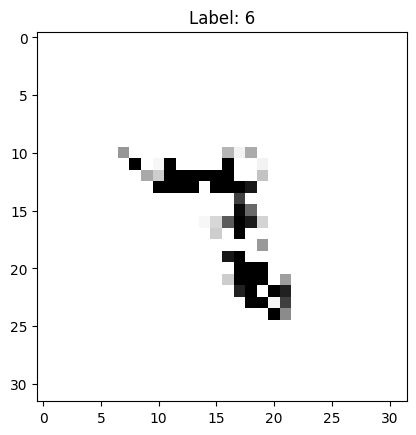

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def show_nth_image(dataloader, n):
    """
    Displays the nth image in the DataLoader.

    Parameters:
    - dataloader: The DataLoader containing the dataset.
    - n: The index of the image to display.
    """
    # Iterate over the DataLoader to get the nth image
    for i, (images, labels) in enumerate(dataloader):
        if i * dataloader.batch_size <= n < (i + 1) * dataloader.batch_size:
            # Get the index of the image in the batch
            index_in_batch = n - i * dataloader.batch_size
            image = images[index_in_batch]
            label = labels[index_in_batch]
            break

    # Convert tensor to numpy array and display
    image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    plt.imshow(image)
    plt.title(f'Label: {label.item()}')
    plt.show()

# Example usage:
# Assuming 'test_loader' is your DataLoader and you want to display the 5th image:
show_nth_image(test_loader, 5)

### Build custom model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image


# Define the CNN Model
class OCRModel(nn.Module):
    def __init__(self, num_classes=10):  # 21 classes for 10 arabic digits
        super(OCRModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Adjusted based on image size (32x32)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Train and evaluation functions for the model

In [ ]:
!pip install livelossplot

In [ ]:
import torch
import numpy as np
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from tqdm import tqdm
import json


def train_one_epoch(train_dataloader, model, optimizer, loss_fn):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_dataloader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        train_loss += loss.item()

    accuracy = 100 * correct / total
    return train_loss / len(train_dataloader), accuracy


def valid_one_epoch(valid_dataloader, model, loss_fn):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in valid_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            valid_loss += loss.item()

    accuracy = 100 * correct / total
    return valid_loss / len(valid_dataloader), accuracy



def optimize(data_loaders, model, optimizer, loss_fn, n_epochs, save_path, json_log_path="performance.json", interactive_tracking=False, patience=3):
    # Initialize tracker for minimum validation loss
    if interactive_tracking:
        liveloss = PlotLosses(outputs=[MatplotlibPlot()])  # For interactive loss tracking
    else:
        liveloss = None

    valid_loss_min = None
    logs = {}

    # Learning rate scheduler: setup a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=0.01)

    # Initialize variables to hold the last epoch's metrics
    last_epoch_metrics = {}

    for epoch in range(1, n_epochs + 1):
        # Training with tqdm progress bar
        model.train()  # Set model to training mode
        train_loss, train_accuracy = 0, 0
        train_steps = len(data_loaders["train"])

        with tqdm(total=train_steps, desc=f"Epoch {epoch} Train", ncols=100) as pbar:
            for batch_idx, (data, target) in enumerate(data_loaders["train"]):
                optimizer.zero_grad()
                output = model(data)
                loss = loss_fn(output, target)
                loss.backward()
                optimizer.step()

                # Calculate accuracy
                pred = output.argmax(dim=1, keepdim=True)
                correct = pred.eq(target.view_as(pred)).sum().item()
                train_accuracy += correct / len(data)  # Update accuracy for each batch

                train_loss += loss.item()  # Accumulate loss
                pbar.set_postfix(loss=train_loss / (batch_idx + 1), accuracy=train_accuracy / (batch_idx + 1) * 100)
                pbar.update(1)

        # Validation with tqdm progress bar
        model.eval()  # Set model to evaluation mode
        valid_loss, valid_accuracy = 0, 0
        valid_steps = len(data_loaders["valid"])

        with tqdm(total=valid_steps, desc=f"Epoch {epoch} Valid", ncols=100) as pbar:
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(data_loaders["valid"]):
                    output = model(data)
                    loss = loss_fn(output, target)

                    # Calculate accuracy
                    pred = output.argmax(dim=1, keepdim=True)
                    correct = pred.eq(target.view_as(pred)).sum().item()
                    valid_accuracy += correct / len(data)  # Update accuracy for each batch

                    valid_loss += loss.item()  # Accumulate loss
                    pbar.set_postfix(loss=valid_loss / (batch_idx + 1), accuracy=valid_accuracy / (batch_idx + 1) * 100)
                    pbar.update(1)

        # Print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tValidation Accuracy: {:.2f}%".format(
                epoch, train_loss / train_steps, valid_loss / valid_steps, train_accuracy / train_steps * 100, valid_accuracy / valid_steps * 100
            )
        )

        # Store the last epoch's metrics
        last_epoch_metrics = {
            "train_accuracy": train_accuracy / train_steps * 100,
            "valid_accuracy": valid_accuracy / valid_steps * 100,
            "train_loss": train_loss / train_steps,
            "valid_loss": valid_loss / valid_steps,
            "learning_rate": optimizer.param_groups[0]["lr"]
        }

        # If the validation loss decreases by more than 1%, save the model
        if valid_loss_min is None or ((valid_loss_min - valid_loss / valid_steps) / valid_loss_min > 0.01):
            print(f"New minimum validation loss: {valid_loss:.6f}. Saving model ...")
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss / valid_steps

        # Update learning rate using scheduler
        scheduler.step(valid_loss / valid_steps)

        # Log to interactive tracker (if active)
        if interactive_tracking:
            logs["loss"] = train_loss / train_steps
            logs["val_loss"] = valid_loss / valid_steps
            logs["lr"] = optimizer.param_groups[0]["lr"]

            liveloss.update(logs)
            liveloss.send()

    # After all epochs, save the last epoch's metrics to the JSON file
    with open(json_log_path, 'w') as f:
        json.dump(last_epoch_metrics, f, indent=4)

    print(f"Last epoch's metrics saved to {json_log_path}")







def one_epoch_test(test_dataloader, model, loss):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    with torch.no_grad():

        # set the model to evaluation mode
        model.eval()

        if torch.cuda.is_available():
            model = model.cuda()

        for batch_idx, (data, target) in tqdm(
                enumerate(test_dataloader),
                desc='Testing',
                total=len(test_dataloader),
                leave=True,
                ncols=80
        ):
            # move data to GPU
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            logits  = model(data)
            # 2. calculate the loss
            loss_value = loss(logits, target)

            # update average test loss
            test_loss = test_loss + (
                (1 / (batch_idx + 1)) * (loss_value.data.item() - test_loss)
            )

            # Convert logits to probabilities and then to predicted class
            probabilities = torch.softmax(logits, dim=1)
            predicted_classes = torch.argmax(probabilities, dim=1)

            # Count correct predictions
            correct += (predicted_classes == target).sum().item()
            total += target.size(0)

    # Calculate accuracy
    accuracy = 100. * correct / total
    print(f'Test Loss: {test_loss:.6f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

### Start Training

In [ ]:
!pwd

/content


In [ ]:
my_model = OCRModel(num_classes=len(label_map))

In [ ]:
# Load the model state dictionary
checkpoint_path = 'best_ocr_model.pth'
state_dict = torch.load(checkpoint_path)

# Load weights into the model
my_model.load_state_dict(state_dict)

# Set the model to training mode
my_model.train()

<ipython-input-21-aabda7574c05>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path)


OCRModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

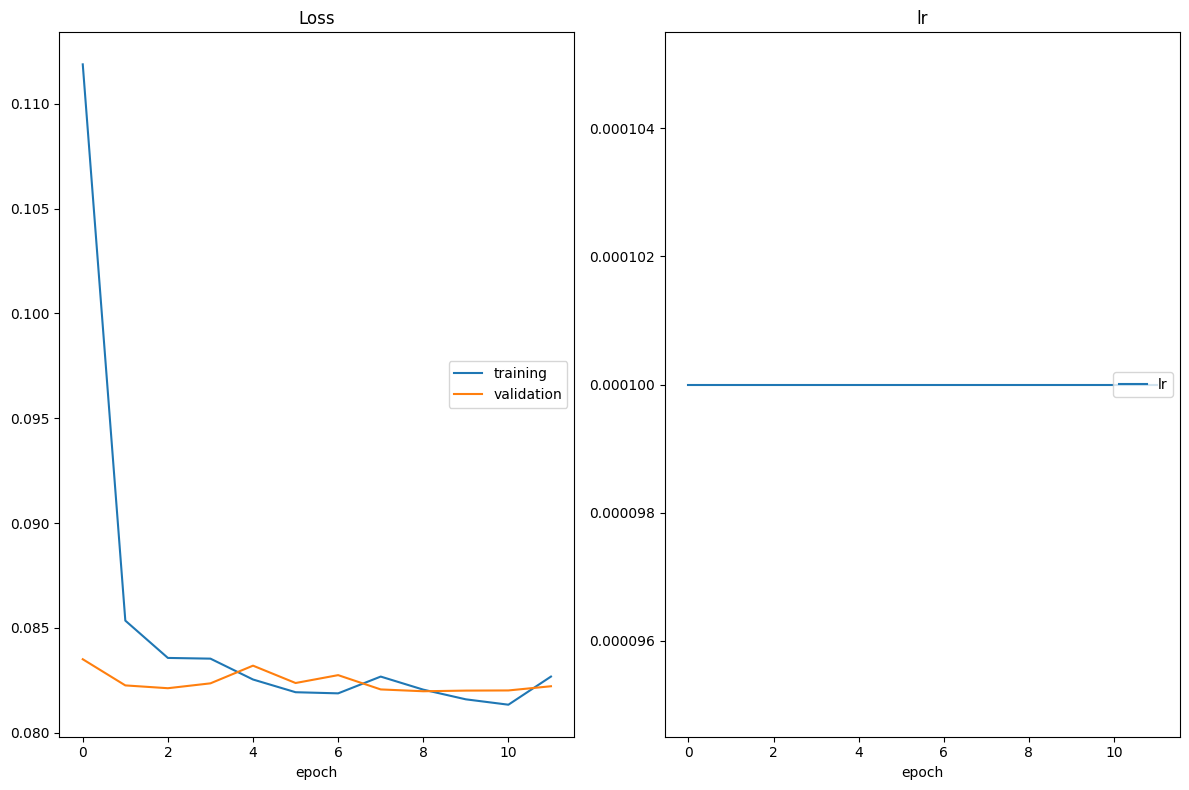

Epoch 13 Train:  18%|███▍               | 196/1094 [00:21<01:38,  9.10it/s, accuracy=96, loss=0.082]


KeyboardInterrupt: 

In [ ]:

optimize(
    data_loaders={
        "train": train_loader,
        "valid": val_loader
    },
    model=my_model,
    optimizer=torch.optim.Adam(my_model.parameters(), lr=0.0001),
    loss_fn=torch.nn.CrossEntropyLoss(),
    n_epochs=50,
    save_path="best_ocr_model.pth",
    interactive_tracking=True,
    patience=5
)

In [ ]:
one_epoch_test(test_loader, my_model, torch.nn.CrossEntropyLoss())

Testing: 100%|████████████████████████████████| 157/157 [00:09<00:00, 15.71it/s]

Test Loss: 0.084913
Test Accuracy: 95.74%


(0.0849129994905803, 95.74)

- after training the code with 5000 digits per each arabic digit, it works perfect on the testing images for all classes, but when talking about `.` and `٥`in arabic digits or `٦` and `٩` digits, there's confliction in prediction with external data.

- I decided to:
  - create a creative data, I'm going to generate data with 5000 samples per each arabic digit as before, but for the digit `٥` I'm going to use 500 images from the generated data, 2000 english `0` digit, non MNIST handwritten dataset and 2500 `o` english letter, as this may makes the `٥` in arabic more unique than `.` arabic zero for the model.

    '٠': 0, '١': 1, '٢': 2, '٣': 3, '٤': 4, '٥': 5, '٦': 6, '٧': 7, '٨': 8, '٩': 9,
  - create 350 arabic `٩` digit, and 4650 samples from the english `9` handwritten non MNIST dataset.

### Convert the model to jit for better deployment

In [ ]:
# Example input tensor (batch_size=1, 3 channels, 32x32 image size)
example_input = torch.randn(1, 3, 32, 32)

# Trace the model (since the model is sequential, tracing should work fine)
traced_model = torch.jit.trace(my_model, example_input)

# Save the traced model
traced_model.save("ocr_model_traced.pt")

# Alternatively, you could script the model if it has control flow:
# scripted_model = torch.jit.script(model)
# scripted_model.save("ocr_model_scripted.pt")

Load the model and make predictions

In [ ]:
# Label map (updated with your digit and special character labels)
label_map = {
    '٠': 0, '١': 1, '٢': 2, '٣': 3, '٤': 4, '٥': 5, '٦': 6, '٧': 7, '٨': 8, '٩': 9,
    #'9': 10, '8': 11, '7': 12, '6': 13, '5': 14, '4': 15, '3': 16, '2': 17, '1': 18, '0': 19, '/': 20
}

In [ ]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize image to 32x32
    transforms.ToTensor(),        # Convert image to Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image to [-1, 1]
])

In [ ]:
import torch
from PIL import Image
from torchvision import transforms

# Step 1: Load the JIT model
loaded_model = torch.jit.load('ocr_model_traced.pt')
loaded_model.eval()  # Set to evaluation mode

# Step 3: Load the image
image_path = '/content/test/٣/٣_1026.png'  # Replace with your image path
image = Image.open(image_path).convert('RGB')  # Ensure it's in RGB format

# Step 4: Apply the transformation
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension (unsqueeze(0))

# Step 5: Make prediction
with torch.no_grad():  # No need for gradients during inference
    output = loaded_model(input_tensor)

# Step 6: Get predicted class
_, predicted_class = torch.max(output, 1)

# Step 7: Print or process the result
print(f"Predicted class: {predicted_class.item()}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/test/٣/٣_1026.png'

In [ ]:
def predict_oc_image(label_map, loaded_model, image_path):
  # Define the transformations
  transform = transforms.Compose([
      transforms.Resize((32, 32)),  # Resize image to 32x32
      transforms.ToTensor(),        # Convert image to Tensor
      transforms.Normalize((0.5,), (0.5,))  # Normalize the image to [-1, 1]
  ])

  # Step 3: Load the image
  image = Image.open(image_path).convert('RGB')  # Ensure it's in RGB format

  # Step 4: Apply the transformation
  input_tensor = transform(image).unsqueeze(0)  # Add batch dimension (unsqueeze(0))

  # Step 5: Make prediction
  with torch.no_grad():  # No need for gradients during inference
      output = loaded_model(input_tensor)

  # Step 6: Get predicted class
  _, predicted_class = torch.max(output, 1)

  inverted_dict = {v: k for k, v in label_map.items()}

  # Step 7: Print or process the result
  print(f"Predicted class: {inverted_dict[predicted_class.item()]}")

In [ ]:
predict_oc_image(label_map, loaded_model, '/content/digit_1.png')

Predicted class: ١


In [ ]:
predict_oc_image(label_map, loaded_model, '/content/test/٥/٥_1039.png')

Predicted class: ٥


In [ ]:
predict_oc_image(label_map, loaded_model, '/content/digit_3.png')

Predicted class: ٠


In [ ]:
predict_oc_image(label_map, loaded_model, '/content/test/٦/٦_1058.png')

Predicted class: ٦


In [ ]:
predict_oc_image(label_map, loaded_model, '/content/digit_2.png')

Predicted class: ٩


In [ ]:
predict_oc_image(label_map, loaded_model, '/content/test/٧/٧_1523.png')

Predicted class: ٧
